# Fine-Tuning BERT on GLUE - CoLA

From [NYU-MLL GLUE/CoLA](https://nyu-mll.github.io/CoLA/):

The Corpus of Linguistic Acceptability (CoLA) in its full form consists of 10657 sentences from 23 linguistics publications, expertly annotated for acceptability (grammaticality) by their original authors. The public version provided here contains 9594 sentences belonging to training and development sets, and excludes 1063 sentences belonging to a held out test set.

## Configuration

In [1]:
import os

# Where to store the huggingface data. On the provided Jupyterlab instance that should be within the shared group folder.
os.environ['HF_HOME'] = '../groups/192.039-2024W/bert/huggingface/cache'

In [2]:
from pathlib import Path

from transformers import set_seed

# RANDOMNESS SEED
SEED = 42
set_seed(SEED)

# Which dataset to load
GLUE_DATASET_NAME = "glue"
GLUE_DATASET_TASK = "cola"

PRE_TRAINED_CHECKPOINT = "google-bert/bert-base-uncased"

TRAIN_OUTPUT_DIR = (
    Path("../groups/192.039-2024W/bert") / "training" / f"{GLUE_DATASET_NAME}-{GLUE_DATASET_TASK}"
)

BATCH_SIZE = 32  # Original Paper claims to use 32 for GLUE tasks
NUM_EPOCHS = 5  # Original Paper claims to use 3 fine-tuning epochs for GLUE tasks

In [3]:
import torch

if torch.cuda.is_available():
  device = torch.device("cuda")
  device_count = torch.cuda.device_count()
  device_name = torch.cuda.get_device_name(0)

  print(f"There are {device_count} GPU(s) available.")
  print(f"GPU used: {device_name}")

else:
  print("No GPU available, using CPU.")
  device = torch.device("cpu")

There are 1 GPU(s) available.
GPU used: NVIDIA GeForce RTX 4060 Ti


## Dataset

In [4]:
from datasets import load_dataset
import pandas as pd

dataset = load_dataset(GLUE_DATASET_NAME, GLUE_DATASET_TASK)
dataset

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 8551
    })
    validation: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 1043
    })
    test: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 1063
    })
})

In [5]:
pd.DataFrame(dataset["train"]).sample(10)

,sentence,label,idx
6199,Who loves who?,1,6199
7650,to hurt oneself is stupid.,1,7650
5104,What you should do is order one first.,1,5104
4847,I wonder on which shelf John will put the book?,1,4847
3404,Sasha lingered over lunch.,1,3404
4742,I ask you if this is what you want.,1,4742
5238,"It's fine that he paid and apologized, but I d...",1,5238
2792,Steve pelted the squirrels with acorns.,1,2792
5656,Louis said that parts of speech intrigued her.,1,5656
4014,The monkey seems despondent.,1,4014


In [6]:
unique_lables_in_dataset = pd.DataFrame(dataset["train"])["label"].unique()
num_labels = len(unique_lables_in_dataset)

print(f"{unique_lables_in_dataset=}")
print(f"{num_labels=}")

unique_lables_in_dataset=array([1, 0])
num_labels=2


## Tokenization

In [7]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(PRE_TRAINED_CHECKPOINT, do_lower_case="uncased" in PRE_TRAINED_CHECKPOINT)

BERT has a maximum sequence length of 512. We can check the sequence lengths resulting from tokenizing our dataset to see if our dataset exceeds this restriction of BERT:

In [8]:
max_len = 0

for sentence in dataset["train"]["sentence"]:
    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(sentence, add_special_tokens=True)
    
    max_len = max(max_len, len(input_ids))

print(f"Max length in train split: {max_len}")
max_len = 0

for sentence in dataset["test"]["sentence"]:
    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(sentence, add_special_tokens=True)
    
    max_len = max(max_len, len(input_ids))

print(f"Max length in test split: {max_len}")
max_len = 0

for sentence in dataset["validation"]["sentence"]:
    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(sentence, add_special_tokens=True)
    
    max_len = max(max_len, len(input_ids))

print(f"Max length in validation split: {max_len}")
max_len = 0


Max length in train split: 47
Max length in test split: 38
Max length in validation split: 35


In [9]:
def tokenize_func(item):
    return tokenizer(item["sentence"], add_special_tokens=True, truncation=True)

tokenized_dataset = dataset.map(tokenize_func, batched=True)

Here is an example of a tokenized dataset item:

In [10]:
dataset["train"][:1]

{'sentence': ["Our friends won't buy this analysis, let alone the next one we propose."],
 'label': [1],
 'idx': [0]}

In [11]:
tokenized_dataset["train"][:1]

{'sentence': ["Our friends won't buy this analysis, let alone the next one we propose."],
 'label': [1],
 'idx': [0],
 'input_ids': [[101,
   2256,
   2814,
   2180,
   1005,
   1056,
   4965,
   2023,
   4106,
   1010,
   2292,
   2894,
   1996,
   2279,
   2028,
   2057,
   16599,
   1012,
   102]],
 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}

Tokenization added the `input_ids` field, which contains the tokenized sentence with a `[CLS]`(101) and a `[SEP]`(102) token added. A `token_type_ids` field which indicates first and second portion of the inputs, if necessary. And an `attention_mask` for the given input.

### Dealing with Padding

Huggingface's `transformers` library provides a `DataCollatorWithPadding` class, which allows us to use dynamic padding.  
Dynamic padding will add `[PAD]` tokens to the length of the longest sequence within a batch, instead of padding to the maximum sequence length within the entire dataset.  
This will avoid unnecessary padding and therefore improve execution efficiency.

In [12]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Example: Select a few samples from the training set
samples = tokenized_dataset["train"][:3]
samples = {k: v for k, v in samples.items() if k not in  ["idx", "sentence"]}  # Drop `idx` and `sentence` columns, as DataCollator can't process those.
pd.DataFrame(samples["input_ids"])

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,101,2256,2814,2180,1005,1056,4965,2023,4106,1010,2292,2894,1996,2279,2028.0,2057.0,16599.0,1012.0,102.0
1,101,2028,2062,18404,2236,3989,1998,1045,1005,1049,3228,2039,1012,102,NaN,NaN,NaN,NaN,NaN
2,101,2028,2062,18404,2236,3989,2030,1045,1005,1049,3228,2039,1012,102,NaN,NaN,NaN,NaN,NaN


In [13]:
examples = [
{"input_ids": [1, 2, 3], "labels": [0]},
{"input_ids": [4, 5], "labels": [1]}, ]

# Apply dynamic padding using data_collator
batch = data_collator(samples)
pd.DataFrame(batch["input_ids"])


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,101,2256,2814,2180,1005,1056,4965,2023,4106,1010,2292,2894,1996,2279,2028,2057,16599,1012,102
1,101,2028,2062,18404,2236,3989,1998,1045,1005,1049,3228,2039,1012,102,0,0,0,0,0
2,101,2028,2062,18404,2236,3989,2030,1045,1005,1049,3228,2039,1012,102,0,0,0,0,0


We can see that `data_collator` will insert `[PAD]` (0) tokens to the maximum length of the passed batch of data items.

## Evaluation

In [14]:
import numpy as np
import evaluate

metric = evaluate.load(GLUE_DATASET_NAME, GLUE_DATASET_TASK)
metric

EvaluationModule(name: "glue", module_type: "metric", features: {'predictions': Value(dtype='int64', id=None), 'references': Value(dtype='int64', id=None)}, usage: """
Compute GLUE evaluation metric associated to each GLUE dataset.
Args:
    predictions: list of predictions to score.
        Each translation should be tokenized into a list of tokens.
    references: list of lists of references for each translation.
        Each reference should be tokenized into a list of tokens.
Returns: depending on the GLUE subset, one or several of:
    "accuracy": Accuracy
    "f1": F1 score
    "pearson": Pearson Correlation
    "spearmanr": Spearman Correlation
    "matthews_correlation": Matthew Correlation
Examples:

    >>> glue_metric = evaluate.load('glue', 'sst2')  # 'sst2' or any of ["mnli", "mnli_mismatched", "mnli_matched", "qnli", "rte", "wnli", "hans"]
    >>> references = [0, 1]
    >>> predictions = [0, 1]
    >>> results = glue_metric.compute(predictions=predictions, references=ref

In [15]:
def get_metric_name_for_specific_task():
    """Helper function to derive the evaluation metric name for the specified GLUE task.

    The tasks specified by the GLUE benchmark use different evaluation metrics.
    Unfortunatly there is no easy way to derive there name after loading the corresponding metric function via HuggingFace's `evaluate` library.
    However we can simply do a "trial run" and expect the name key of its output.
    """
    output = metric.compute(
        predictions=[1, 0], references=[1, 1]
    )  # dummy input - we just want to inspect the returned dictionary.
    metric_name = next(iter(output))  # simply gets first key of output
    return metric_name


metric_name = get_metric_name_for_specific_task()
print(f'We will use "{metric_name}" as an evaluation metric for the task {GLUE_DATASET_TASK}')

We will use "matthews_correlation" as an evaluation metric for the task cola


# Training

In [16]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(
    PRE_TRAINED_CHECKPOINT,
    num_labels=num_labels,
    torch_dtype="auto",
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [17]:
from transformers import TrainingArguments

training_arguments = TrainingArguments(
    output_dir=TRAIN_OUTPUT_DIR,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    eval_strategy="steps",
    eval_steps=100,
    save_strategy="steps",
    save_steps=100,
    logging_strategy="steps",
    logging_steps=100,
    num_train_epochs=NUM_EPOCHS,
    learning_rate=2e-5,  # Original paper uses best out of  5e-5, 4e-5, 3e-5, and 2e-5
    weight_decay=0.01,  # Original paper uses 0.01 on pre-training
    load_best_model_at_end=True,
    metric_for_best_model=metric_name,
)

In [18]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    if GLUE_DATASET_TASK != "stsb":
        predictions = np.argmax(predictions, axis=1)
    else:
        predictions = predictions[:, 0]
    return metric.compute(predictions=predictions, references=labels)

In [19]:
from transformers import Trainer

validation_key = "validation_mismatched" if GLUE_DATASET_TASK == "mnli-mm" else "validation_matched" if GLUE_DATASET_TASK == "mnli" else "validation"

trainer = Trainer(
    model=model,
    args=training_arguments,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset[validation_key],
    data_collator=data_collator,
    processing_class=tokenizer,
    compute_metrics=compute_metrics
)

In [20]:
torch.cuda.empty_cache()

print(f"--- {training_arguments.output_dir=}")
training_summary = trainer.train()

--- training_arguments.output_dir='../groups/192.039-2024W/bert/training/glue-cola'


  0%|          | 0/1340 [00:00<?, ?it/s]

{'loss': 0.5283, 'grad_norm': 5.498426914215088, 'learning_rate': 1.8507462686567165e-05, 'epoch': 0.37}


  0%|          | 0/33 [00:00<?, ?it/s]

{'eval_loss': 0.47185271978378296, 'eval_matthews_correlation': 0.49380532984629394, 'eval_runtime': 0.5479, 'eval_samples_per_second': 1903.785, 'eval_steps_per_second': 60.235, 'epoch': 0.37}
{'loss': 0.4556, 'grad_norm': 4.645875453948975, 'learning_rate': 1.701492537313433e-05, 'epoch': 0.75}


  0%|          | 0/33 [00:00<?, ?it/s]

{'eval_loss': 0.44142094254493713, 'eval_matthews_correlation': 0.5245973684146213, 'eval_runtime': 0.552, 'eval_samples_per_second': 1889.495, 'eval_steps_per_second': 59.783, 'epoch': 0.75}
{'loss': 0.3903, 'grad_norm': 7.003178596496582, 'learning_rate': 1.5522388059701494e-05, 'epoch': 1.12}


  0%|          | 0/33 [00:00<?, ?it/s]

{'eval_loss': 0.4684695899486542, 'eval_matthews_correlation': 0.5578770438298012, 'eval_runtime': 0.564, 'eval_samples_per_second': 1849.162, 'eval_steps_per_second': 58.507, 'epoch': 1.12}
{'loss': 0.2948, 'grad_norm': 7.371007919311523, 'learning_rate': 1.4029850746268658e-05, 'epoch': 1.49}


  0%|          | 0/33 [00:00<?, ?it/s]

{'eval_loss': 0.48211026191711426, 'eval_matthews_correlation': 0.5153179547856604, 'eval_runtime': 0.5506, 'eval_samples_per_second': 1894.416, 'eval_steps_per_second': 59.938, 'epoch': 1.49}
{'loss': 0.2902, 'grad_norm': 12.28109359741211, 'learning_rate': 1.2537313432835823e-05, 'epoch': 1.87}


  0%|          | 0/33 [00:00<?, ?it/s]

{'eval_loss': 0.5093415975570679, 'eval_matthews_correlation': 0.5523181756655187, 'eval_runtime': 0.5528, 'eval_samples_per_second': 1886.921, 'eval_steps_per_second': 59.701, 'epoch': 1.87}
{'loss': 0.2282, 'grad_norm': 10.120359420776367, 'learning_rate': 1.1044776119402986e-05, 'epoch': 2.24}


  0%|          | 0/33 [00:00<?, ?it/s]

{'eval_loss': 0.5063227415084839, 'eval_matthews_correlation': 0.5703054933279827, 'eval_runtime': 0.5516, 'eval_samples_per_second': 1891.007, 'eval_steps_per_second': 59.831, 'epoch': 2.24}
{'loss': 0.1836, 'grad_norm': 12.957316398620605, 'learning_rate': 9.552238805970149e-06, 'epoch': 2.61}


  0%|          | 0/33 [00:00<?, ?it/s]

{'eval_loss': 0.6191191077232361, 'eval_matthews_correlation': 0.5392832081618074, 'eval_runtime': 0.5452, 'eval_samples_per_second': 1913.184, 'eval_steps_per_second': 60.532, 'epoch': 2.61}
{'loss': 0.1758, 'grad_norm': 7.420416831970215, 'learning_rate': 8.059701492537314e-06, 'epoch': 2.99}


  0%|          | 0/33 [00:00<?, ?it/s]

{'eval_loss': 0.5968910455703735, 'eval_matthews_correlation': 0.5649812173768567, 'eval_runtime': 0.5612, 'eval_samples_per_second': 1858.477, 'eval_steps_per_second': 58.801, 'epoch': 2.99}
{'loss': 0.1343, 'grad_norm': 13.23167896270752, 'learning_rate': 6.567164179104478e-06, 'epoch': 3.36}


  0%|          | 0/33 [00:00<?, ?it/s]

{'eval_loss': 0.5776035785675049, 'eval_matthews_correlation': 0.5896871028466439, 'eval_runtime': 0.5486, 'eval_samples_per_second': 1901.141, 'eval_steps_per_second': 60.151, 'epoch': 3.36}
{'loss': 0.1272, 'grad_norm': 3.252612352371216, 'learning_rate': 5.074626865671642e-06, 'epoch': 3.73}


  0%|          | 0/33 [00:00<?, ?it/s]

{'eval_loss': 0.6676148176193237, 'eval_matthews_correlation': 0.5468696296312392, 'eval_runtime': 0.5536, 'eval_samples_per_second': 1884.09, 'eval_steps_per_second': 59.612, 'epoch': 3.73}
{'loss': 0.1127, 'grad_norm': 7.096395015716553, 'learning_rate': 3.582089552238806e-06, 'epoch': 4.1}


  0%|          | 0/33 [00:00<?, ?it/s]

{'eval_loss': 0.6872794032096863, 'eval_matthews_correlation': 0.572700939299986, 'eval_runtime': 0.5579, 'eval_samples_per_second': 1869.397, 'eval_steps_per_second': 59.147, 'epoch': 4.1}
{'loss': 0.0826, 'grad_norm': 0.5039080381393433, 'learning_rate': 2.08955223880597e-06, 'epoch': 4.48}


  0%|          | 0/33 [00:00<?, ?it/s]

{'eval_loss': 0.7393803596496582, 'eval_matthews_correlation': 0.5777940781336061, 'eval_runtime': 0.5532, 'eval_samples_per_second': 1885.498, 'eval_steps_per_second': 59.656, 'epoch': 4.48}
{'loss': 0.0832, 'grad_norm': 5.909607410430908, 'learning_rate': 5.970149253731343e-07, 'epoch': 4.85}


  0%|          | 0/33 [00:00<?, ?it/s]

{'eval_loss': 0.7518392205238342, 'eval_matthews_correlation': 0.593197037544882, 'eval_runtime': 0.5671, 'eval_samples_per_second': 1839.065, 'eval_steps_per_second': 58.187, 'epoch': 4.85}
{'train_runtime': 148.4195, 'train_samples_per_second': 288.069, 'train_steps_per_second': 9.028, 'train_loss': 0.23324372145667005, 'epoch': 5.0}


In [21]:
training_summary

TrainOutput(global_step=1340, training_loss=0.23324372145667005, metrics={'train_runtime': 148.4195, 'train_samples_per_second': 288.069, 'train_steps_per_second': 9.028, 'total_flos': 506607489876180.0, 'train_loss': 0.23324372145667005, 'epoch': 5.0})

We can call `trainer.evaluate()` to check that the `trainer` instance did indeed reload the model checkpoint with the highest evaluation score:

In [32]:
best_model_evaluation = trainer.evaluate()
best_model_evaluation

  0%|          | 0/33 [00:00<?, ?it/s]

{'eval_loss': 0.7518392205238342,
 'eval_matthews_correlation': 0.593197037544882,
 'eval_runtime': 0.5883,
 'eval_samples_per_second': 1772.794,
 'eval_steps_per_second': 56.09,
 'epoch': 5.0}

In [48]:
training_history = pd.DataFrame(trainer.state.log_history)
training_history.groupby("step").first()

,loss,grad_norm,learning_rate,epoch,eval_loss,eval_matthews_correlation,eval_runtime,eval_samples_per_second,eval_steps_per_second,train_runtime,train_samples_per_second,train_steps_per_second,total_flos,train_loss
step,,,,,,,,,,,,,,
100,0.5283,5.498427,1.850746e-05,0.373134,0.471853,0.493805,0.5479,1903.785,60.235,NaN,NaN,NaN,NaN,NaN
200,0.4556,4.645875,1.701493e-05,0.746269,0.441421,0.524597,0.5520,1889.495,59.783,NaN,NaN,NaN,NaN,NaN
300,0.3903,7.003179,1.552239e-05,1.119403,0.468470,0.557877,0.5640,1849.162,58.507,NaN,NaN,NaN,NaN,NaN
400,0.2948,7.371008,1.402985e-05,1.492537,0.482110,0.515318,0.5506,1894.416,59.938,NaN,NaN,NaN,NaN,NaN
500,0.2902,12.281094,1.253731e-05,1.865672,0.509342,0.552318,0.5528,1886.921,59.701,NaN,NaN,NaN,NaN,NaN
600,0.2282,10.120359,1.104478e-05,2.238806,0.506323,0.570305,0.5516,1891.007,59.831,NaN,NaN,NaN,NaN,NaN
700,0.1836,12.957316,9.552239e-06,2.611940,0.619119,0.539283,0.5452,1913.184,60.532,NaN,NaN,NaN,NaN,NaN
800,0.1758,7.420417,8.059701e-06,2.985075,0.596891,0.564981,0.5612,1858.477,58.801,NaN,NaN,NaN,NaN,NaN
900,0.1343,13.231679,6.567164e-06,3.358209,0.577604,0.589687,0.5486,1901.141,60.151,NaN,NaN,NaN,NaN,NaN


### Loss and Evaluation Metrics over Training Steps

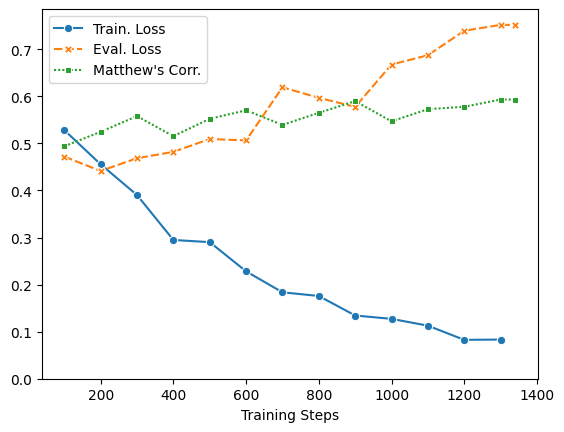

In [ ]:
import seaborn as sns

data = training_history[["loss", "eval_loss", "step", f"eval_{metric_name}"]]
data.columns = ["Train. Loss", "Eval. Loss", "Training Steps", "Matthew's Corr."]
data = pd.melt(data, ['Training Steps'])

plot = sns.lineplot(data=data, x="Training Steps", y="value", hue="variable", style="variable", markers=True)
plot.set_ylabel("")
plot.set_ylim((0, plot.get_ylim()[1]))
plot.legend(title="")

from IPython.display import Markdown, display
display(Markdown("### Loss and Evaluation Metrics over Training Steps"))

In [39]:
display(Markdown(f"### Best Model performance:"))
pd.DataFrame(
    best_model_evaluation.values(),
    index=best_model_evaluation.keys(),
    columns=["values"],
).drop(
    # Drop runtime measurements
    index=["eval_runtime", "eval_samples_per_second", "eval_steps_per_second", "epoch"]
)

### Best Model performance:

,values
eval_loss,0.751839
eval_matthews_correlation,0.593197
